In [8]:
import pandas as pd
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
df = pd.read_pickle('/content/drive/My Drive/Northwestern MS/453 - Natural Language Processing/imdb/imdb_dataset.pkl')
df.head()

,review,sentiment,processed
0,One of the other reviewers has mentioned that ...,positive,"[[reviewer, mention, watch, oz, episode, hook,..."
1,A wonderful little production. <br /><br />The...,positive,"[[wonderful, little, production, filming, tech..."
2,I thought this was a wonderful way to spend ti...,positive,"[[think, wonderful, way, spend, time, hot, sum..."
3,Basically there's a family where a little boy ...,negative,"[[basically, family, little, boy, jake, think,..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"[[petter, matteis, love, time, money, visually..."


In [11]:
# Combine the processed tokens back into strings for Doc2Vec
df['processed_text'] = df['processed'].apply(lambda x: ' '.join([' '.join(tokens) for tokens in x]))

In [12]:
# Tokenize the processed text
tokenized_texts = df['processed'].tolist()
tokenized_texts = [text for text in tokenized_texts if text]  # Remove empty lists

# Flatten the tokenized texts
flattened_texts = [word for sublist in tokenized_texts for word in sublist]

# Create bigrams and trigrams using Phrases
bigram = Phrases(flattened_texts, min_count=5, threshold=100)
trigram = Phrases(bigram[flattened_texts], threshold=100)

bigram_phraser = Phraser(bigram)
trigram_phraser = Phraser(trigram)

# Apply bigrams and trigrams to the tokenized texts
texts_with_ngrams = [trigram_phraser[bigram_phraser[text]] for text in tokenized_texts]

In [13]:
# Prepare data for Doc2Vec
documents = []
for i, text in enumerate(texts_with_ngrams):
    # Flatten any nested lists within text
    if any(isinstance(i, list) for i in text):
        text = [item for sublist in text for item in sublist]
    documents.append(TaggedDocument(words=text, tags=[str(i)]))

# Ensure that each element in documents is a TaggedDocument and words are lists of strings
for doc in documents:
    assert isinstance(doc, TaggedDocument), f"Expected TaggedDocument, got {type(doc)}"
    assert all(isinstance(word, str) for word in doc.words), "Each word should be a string"

# Train a Doc2Vec model
doc2vec_model = Doc2Vec(vector_size=100, window=5, min_count=2, workers=4, epochs=40)
doc2vec_model.build_vocab(documents)
doc2vec_model.train(documents, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)


In [14]:
# Get document vectors
doc_vectors = [doc2vec_model.dv[str(i)] for i in range(len(documents))]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

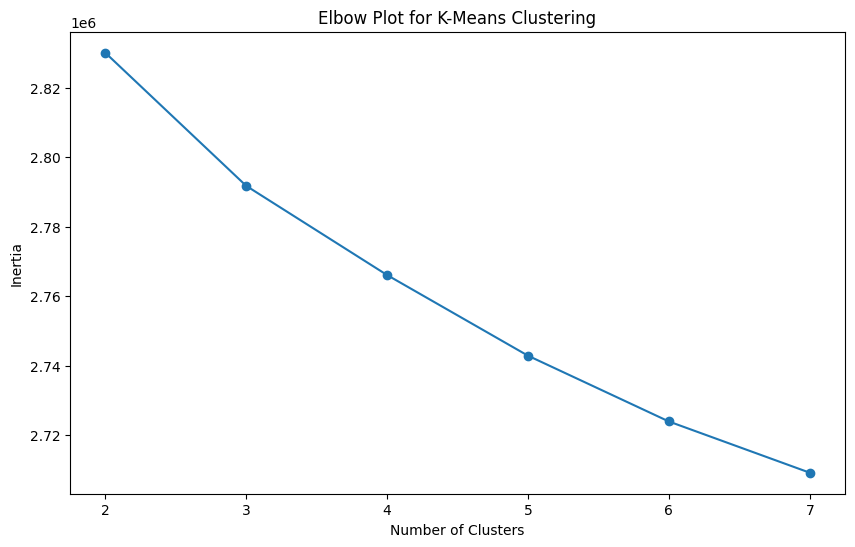

In [15]:
# Test different numbers of clusters for K-Means
inertia = []
silhouette_scores = []
cluster_range = range(2, 8)

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(doc_vectors)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(doc_vectors, kmeans_labels))

# Plot the elbow plot for inertia
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia, marker='o')
plt.title('Elbow Plot for K-Means Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(cluster_range)
plt.show()

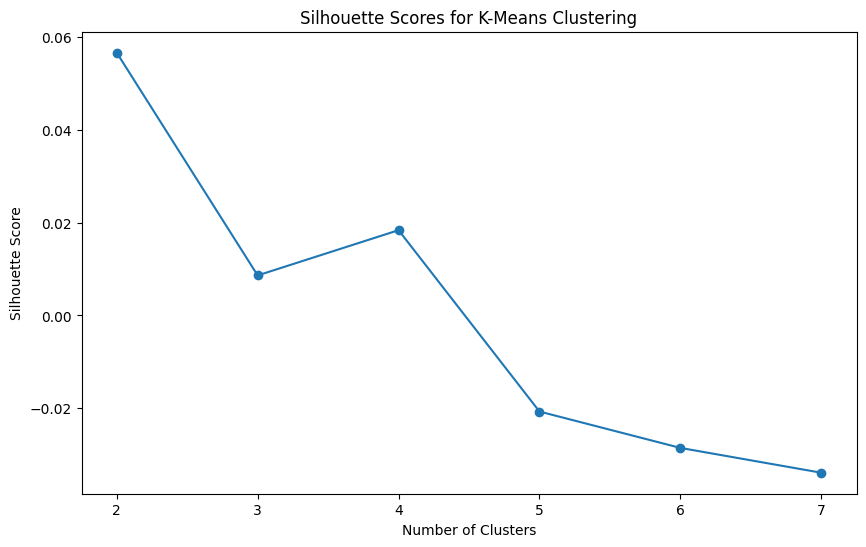

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [16]:
# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Scores for K-Means Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(cluster_range)
plt.show()

# Select the optimal number of clusters based on the elbow plot or silhouette score
optimal_clusters = 2  # Example: Based on the plots, choose an optimal number of clusters

# Apply K-Means with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(doc_vectors)

In [17]:
# Define additional hyperparameters for Agglomerative Clustering suitable for text
agg_clustering = AgglomerativeClustering(
    n_clusters=optimal_clusters,  # Number of clusters
    affinity='cosine',            # Metric used to compute the linkage
    linkage='average',            # Linkage criterion to use
    distance_threshold=None       # No distance threshold (using n_clusters)
)

# Apply Agglomerative Clustering
agg_labels = agg_clustering.fit_predict(doc_vectors)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [18]:
# Print silhouette scores for the chosen number of clusters
print(f"K-Means Silhouette Score (optimal clusters): {silhouette_score(doc_vectors, kmeans_labels)}")
print(f"Agglomerative Clustering Silhouette Score (optimal clusters): {silhouette_score(doc_vectors, agg_labels)}")

# Add cluster labels to the dataframe
df['kmeans_cluster'] = kmeans_labels
df['agg_cluster'] = agg_labels

K-Means Silhouette Score (optimal clusters): 0.05661711096763611
Agglomerative Clustering Silhouette Score (optimal clusters): 0.13032276928424835


In [19]:
# Visualize the clusters using PCA
pca = PCA(n_components=2)
doc_vectors_2d = pca.fit_transform(doc_vectors)

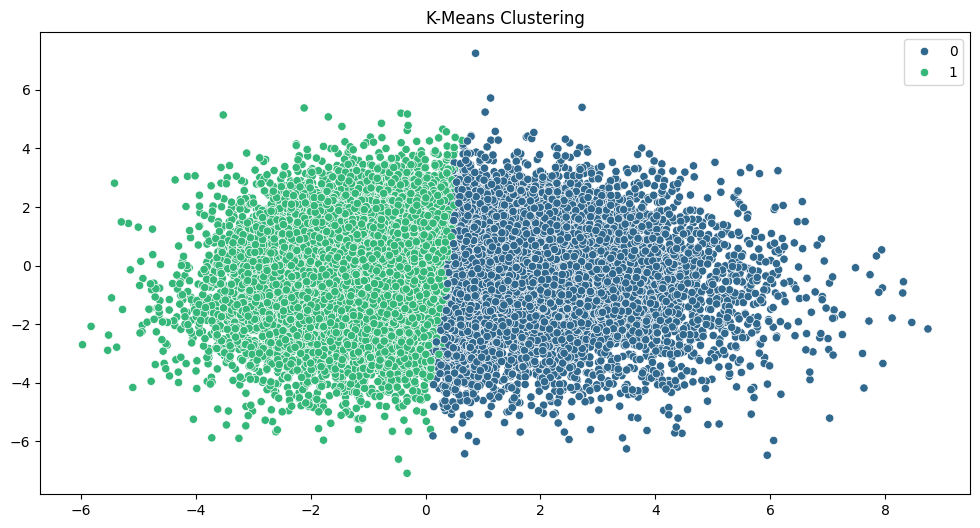

In [20]:
# K-Means Clusters
plt.figure(figsize=(12, 6))
sns.scatterplot(x=doc_vectors_2d[:, 0], y=doc_vectors_2d[:, 1], hue=kmeans_labels, palette="viridis", legend="full")
plt.title("K-Means Clustering")
plt.show()

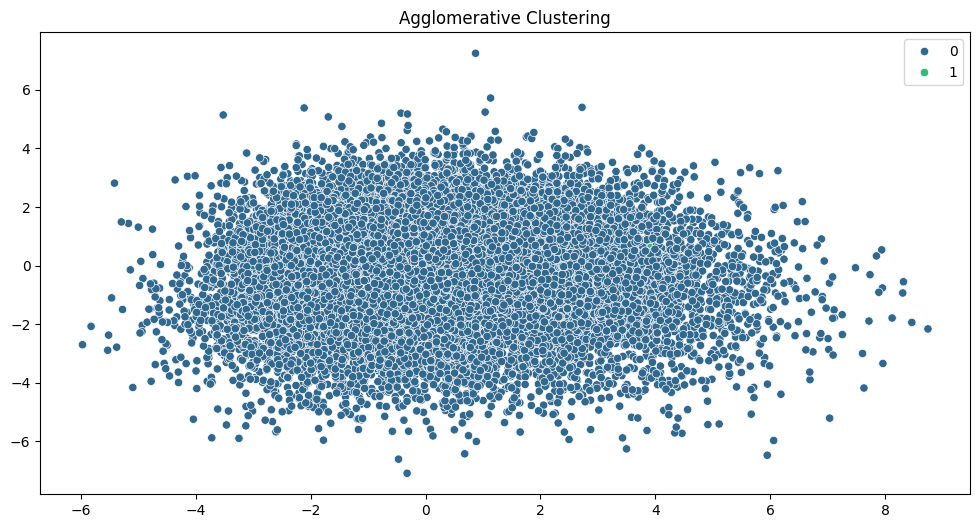

In [21]:
# Agglomerative Clustering
plt.figure(figsize=(12, 6))
sns.scatterplot(x=doc_vectors_2d[:, 0], y=doc_vectors_2d[:, 1], hue=agg_labels, palette="viridis", legend="full")
plt.title("Agglomerative Clustering")
plt.show()


In [22]:
# Convert sentiment labels to numerical format if necessary
df['sentiment_num'] = df['sentiment'].astype('category').cat.codes

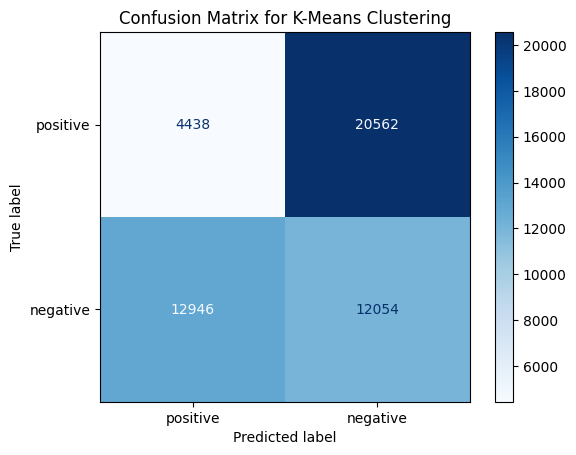

K-Means Clustering - Accuracy: 0.33, Precision: 0.31, Recall: 0.33





In [23]:
# Generate confusion matrix and metrics for K-Means clusters
kmeans_cm = confusion_matrix(df['sentiment_num'], df['kmeans_cluster'])
kmeans_disp = ConfusionMatrixDisplay(confusion_matrix=kmeans_cm, display_labels=df['sentiment'].unique())
kmeans_disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for K-Means Clustering')
plt.show()

kmeans_accuracy = accuracy_score(df['sentiment_num'], df['kmeans_cluster'])
kmeans_precision = precision_score(df['sentiment_num'], df['kmeans_cluster'], average='macro')
kmeans_recall = recall_score(df['sentiment_num'], df['kmeans_cluster'], average='macro')

print(f"K-Means Clustering - Accuracy: {kmeans_accuracy:.2f}, Precision: {kmeans_precision:.2f}, Recall: {kmeans_recall:.2f}")
print('\n\n')

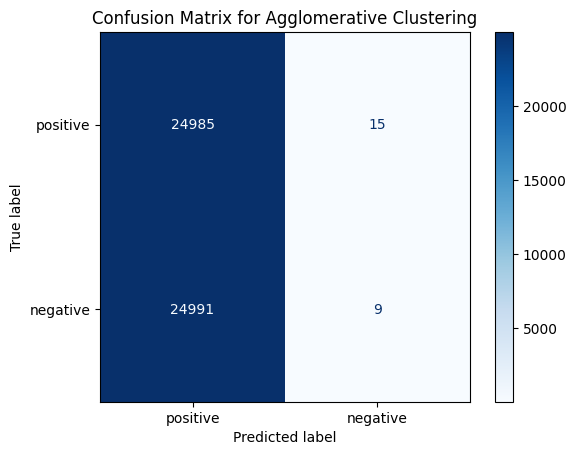

Agglomerative Clustering - Accuracy: 0.50, Precision: 0.44, Recall: 0.50


In [24]:
# Generate confusion matrix and metrics for Agglomerative Clustering
agg_cm = confusion_matrix(df['sentiment_num'], df['agg_cluster'])
agg_disp = ConfusionMatrixDisplay(confusion_matrix=agg_cm, display_labels=df['sentiment'].unique())
agg_disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Agglomerative Clustering')
plt.show()

agg_accuracy = accuracy_score(df['sentiment_num'], df['agg_cluster'])
agg_precision = precision_score(df['sentiment_num'], df['agg_cluster'], average='macro')
agg_recall = recall_score(df['sentiment_num'], df['agg_cluster'], average='macro')

print(f"Agglomerative Clustering - Accuracy: {agg_accuracy:.2f}, Precision: {agg_precision:.2f}, Recall: {agg_recall:.2f}")


K-Means Clustering achieved an accuracy of 33%, which is significantly lower compared to Agglomerative Clustering, which achieved an accuracy of 50%. This suggests that Agglomerative Clustering performs better overall in correctly classifying the sentiment labels.
Precision:

K-Means Clustering has a precision of 31%, meaning that only 31% of the instances predicted as positive are actually positive. On the other hand, Agglomerative Clustering has a higher precision of 44%, indicating better reliability in its positive predictions.
Recall:

The recall for K-Means Clustering is 33%, which indicates that it correctly identifies 33% of all actual positive instances. Agglomerative Clustering shows a recall of 50%, which means it correctly identifies half of the actual positive instances.
Confusion Matrix Insights:

K-Means Clustering shows a significant number of false negatives (20562), indicating that many actual positives are being misclassified as negatives.
Agglomerative Clustering shows an almost equal distribution of predicted positives and negatives, but with very few true negatives (9), suggesting a high rate of false positives (24991).


### Summary
Agglomerative Clustering demonstrates better overall performance compared to K-Means Clustering in terms of accuracy, precision, and recall. However, the high number of false positives in Agglomerative Clustering indicates a potential issue with misclassifying negative instances as positive.
K-Means Clustering struggles significantly with recall, indicating it is missing a large number of actual positive instances.
For the given task, Agglomerative Clustering is preferable due to its higher accuracy and precision, despite its issues with false positives. Further tuning and perhaps exploring additional clustering methods or preprocessing steps might improve the results further.